<a href="https://colab.research.google.com/github/juang1910/Radiographies/blob/main/radiographies.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importar cosas necesarias

In [ ]:

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import random_split, TensorDataset
from torchvision import datasets, transforms
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from PIL import Image
import os
import cv2
import matplotlib.pyplot as plt
import torch.optim as optim



if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print(device)

cuda


Adding dataset from github

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

!git clone https://github.com/juang1910/Radiographies.git
!git config --global credential.helper cache



Cloning into 'Radiographies'...
fatal: could not read Username for 'https://github.com': No such device or address


## **Carga de los datos**

In [ ]:
# Definir transformaciones para preprocesar las imágenes
transform = transforms.Compose([
    transforms.Resize((112, 112)),  # Redimensionar las imágenes a 224x224 píxeles
    transforms.ToTensor(),    # Convertir las imágenes a tensores
    transforms.Normalize([0.2184, 0.2184, 0.2184],[0.2088, 0.2088, 0.2088])
])

# Rutas de las carpetas con las imágenes
#data_dir = '/content/drive/MyDrive/USP/D2024-1/data'
data_dir = 'Radiographies/data'

# Cargar conjunto de datos de entrenamiento
train_dataset = datasets.ImageFolder(root=os.path.join(data_dir, 'train'), transform=transform)

# Obtener el número total de imágenes en la carpeta de entrenamiento
total_train_images = len(train_dataset)

# Determinar el número de imágenes para el conjunto de validación y el conjunto de entrenamiento
num_val_images = 1000
num_train_images = total_train_images - num_val_images

# Dividir las imágenes en dos conjuntos de datos: validación y entrenamiento
val_dataset, train_dataset = torch.utils.data.random_split(train_dataset, [num_val_images, num_train_images])

# Cargar conjunto de datos de prueba (usar todas las imágenes de la carpeta "val")
test_dataset = datasets.ImageFolder(root=os.path.join(data_dir, 'val'), transform=transform)

# Definir DataLoader para cargar los datos de entrenamiento, validación y prueba
batch_size = 32
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Verificar el tamaño de los conjuntos de datos de entrenamiento, validación y prueba
print("Número total de imágenes de entrenamiento:", len(train_dataset))
print("Número total de imágenes de validación:", len(val_dataset))
print("Número total de imágenes de prueba:", len(test_dataset))

Número total de imágenes de entrenamiento: 7863
Número total de imágenes de validación: 1000
Número total de imágenes de prueba: 600


In [ ]:
imgs, _ = next(iter(train_loader))
print("Batch mean", imgs.mean(dim=[0,2,3]))
print("Batch std", imgs.std(dim=[0,2,3]))

Batch mean tensor([-0.0478, -0.0478, -0.0478])
Batch std tensor([1.0090, 1.0090, 1.0090])


## Calculo de media y desviación estandar

In [ ]:
# Calcular la media y la desviación estándar de las imágenes
loader = torch.utils.data.DataLoader(dataset, batch_size=len(dataset), shuffle=False)
data = next(iter(loader))
images = data[0]

mean = torch.mean(images, dim=(0, 2, 3))  # Calcular la media de todas las imágenes en el dataset
std = torch.std(images, dim=(0, 2, 3))    # Calcular la desviación estándar de todas las imágenes en el dataset

print("Media de las imágenes:", mean)
print("Desviación estándar de las imágenes:", std)

Media de las imágenes: tensor([0.2184, 0.2184, 0.2184])
Desviación estándar de las imágenes: tensor([0.2088, 0.2088, 0.2088])


## Mostrar una imagen

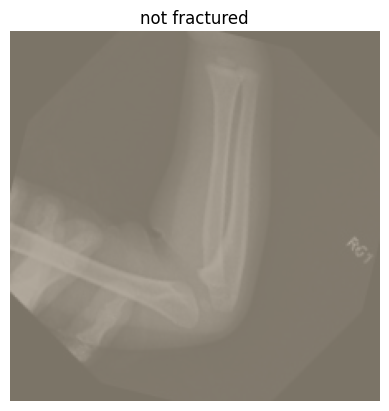

In [ ]:


# Obtener la primera iteración del DataLoader para obtener la primera imagen
images, labels = next(iter(train_loader))

# Obtener la primera imagen y su etiqueta
image = images[0]
label = labels[0]

# Convertir la imagen de tensor a NumPy y cambiar las dimensiones para matplotlib
image_np = image.numpy().transpose((1, 2, 0))

# Desnormalizar la imagen (inversa de la transformación ToTensor())
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
image_np = std * image_np + mean
image_np = np.clip(image_np, 0, 1)  # Asegurar que los valores estén en el rango [0, 1]

# Imprimir la imagen y su etiqueta
plt.imshow(image_np)
plt.title(dataset.classes[label])
plt.axis('off')
plt.show()

In [ ]:
try:
    import pytorch_lightning as pl
except ModuleNotFoundError: # Google Colab does not have PyTorch Lightning installed by default. Hence, we do it here if necessary
    !pip install --quiet pytorch-lightning>=1.5
    import pytorch_lightning as pl

# Setting the seed
pl.seed_everything(42)

INFO:lightning_fabric.utilities.seed:Seed set to 42


42

## **Funcion accuracy**

In [ ]:
#for i, (x,y) in enumerate(test_loader):
    #print(i, x.shape, y.shape)

In [ ]:
def accuracy(model, loader):
    num_correct = 0
    num_total = 0
    model.eval()
    model = model.to(device=device)
    with torch.no_grad():
        for xi, yi in loader:
            xi = xi.to(device=device, dtype = torch.float32)
            yi = yi.to(device=device, dtype = torch.long)
            scores = model(xi)
            _, pred = scores.max(dim=1)
            num_correct += (pred == yi).sum()
            num_total += pred.size(0)
        return float(num_correct)/num_total

## **Inception block**

In [ ]:
class InceptionBlock(nn.Module):

    def __init__(self, c_in, c_red : dict, c_out : dict, act_fn):
        """
        Inputs:
            c_in - Number of input feature maps from the previous layers
            c_red - Dictionary with keys "3x3" and "5x5" specifying the output of the dimensionality reducing 1x1 convolutions
            c_out - Dictionary with keys "1x1", "3x3", "5x5", and "max"
            act_fn - Activation class constructor (e.g. nn.ReLU)
        """
        super().__init__()

        # 1x1 convolution branch
        self.conv_1x1 = nn.Sequential(
            nn.Conv2d(c_in, c_out["1x1"], kernel_size=1),
            nn.BatchNorm2d(c_out["1x1"]),
            act_fn()
        )

        # 3x3 convolution branch
        self.conv_3x3 = nn.Sequential(
            nn.Conv2d(c_in, c_red["3x3"], kernel_size=1),
            nn.BatchNorm2d(c_red["3x3"]),
            act_fn(),
            nn.Conv2d(c_red["3x3"], c_out["3x3"], kernel_size=3, padding=1),
            nn.BatchNorm2d(c_out["3x3"]),
            act_fn()
        )

        # 5x5 convolution branch
        self.conv_5x5 = nn.Sequential(
            nn.Conv2d(c_in, c_red["5x5"], kernel_size=1),
            nn.BatchNorm2d(c_red["5x5"]),
            act_fn(),
            nn.Conv2d(c_red["5x5"], c_out["5x5"], kernel_size=5, padding=2),
            nn.BatchNorm2d(c_out["5x5"]),
            act_fn()
        )

        # Max-pool branch
        self.max_pool = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, padding=1, stride=1),
            nn.Conv2d(c_in, c_out["max"], kernel_size=1),
            nn.BatchNorm2d(c_out["max"]),
            act_fn()
        )

    def forward(self, x):
        x_1x1 = self.conv_1x1(x)
        x_3x3 = self.conv_3x3(x)
        x_5x5 = self.conv_5x5(x)
        x_max = self.max_pool(x)
        x_out = torch.cat([x_1x1, x_3x3, x_5x5, x_max], dim=1)
        return x_out

In [ ]:
class RadiographiesNet(nn.Module):
    def __init__(self, num_classes=2, act_fn=nn.ReLU):
        super(RadiographiesNet, self).__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3),
            nn.BatchNorm2d(64),
            act_fn(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )

        self.inception1 = InceptionBlock(c_in=64, c_red={"3x3": 32, "5x5": 32}, c_out={"1x1": 64, "3x3": 64, "5x5": 64, "max": 64}, act_fn=act_fn)
        self.inception2 = InceptionBlock(c_in=256, c_red={"3x3": 64, "5x5": 64}, c_out={"1x1": 128, "3x3": 128, "5x5": 128, "max": 128}, act_fn=act_fn)

        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.inception1(x)
        x = self.inception2(x)
        x = self.pool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

def createNetwork(num_classes=2):
    return RadiographiesNet(num_classes=num_classes)

Epoch 1/10, Training Loss: 0.5548832276003147, Validation Loss: 0.40404756367206573
Epoch 2/10, Training Loss: 0.4035433315164675, Validation Loss: 0.42047197045758367
Epoch 3/10, Training Loss: 0.27456005856515914, Validation Loss: 0.4123247158713639
Epoch 4/10, Training Loss: 0.1932088140761707, Validation Loss: 0.19231964612845331
Epoch 5/10, Training Loss: 0.13770017694167005, Validation Loss: 0.253591971937567
Epoch 6/10, Training Loss: 0.09770795675676043, Validation Loss: 0.09545387531397864
Epoch 7/10, Training Loss: 0.0978690646513085, Validation Loss: 0.06567854329477996
Epoch 8/10, Training Loss: 0.0637508087272839, Validation Loss: 0.09252355455828365
Epoch 9/10, Training Loss: 0.06912293892762647, Validation Loss: 0.0900540049187839
Epoch 10/10, Training Loss: 0.04048107913127396, Validation Loss: 0.047768276308488566


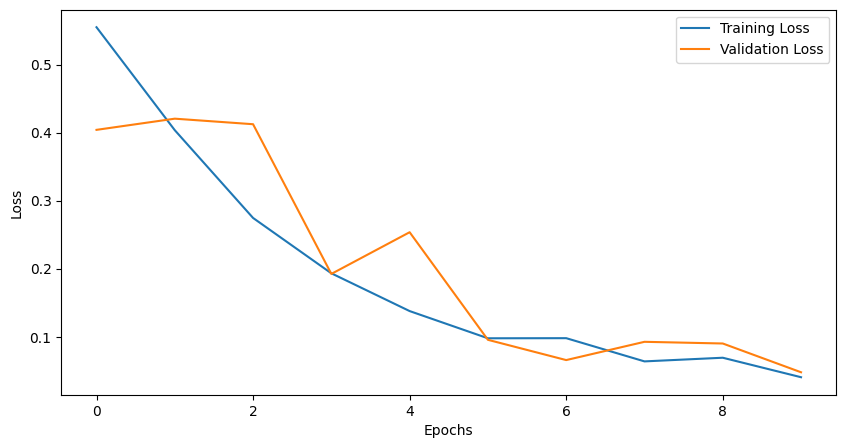

In [ ]:
# Configurar dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = createNetwork(num_classes=2)
model = model.to(device)

# Definir la función de pérdida y el optimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Entrenar el modelo
num_epochs = 10
train_loss_history = []
val_loss_history = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_loss_history.append(running_loss / len(train_loader))

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    val_loss_history.append(val_loss / len(val_loader))

    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {train_loss_history[-1]}, Validation Loss: {val_loss_history[-1]}")

# Graficar la pérdida de entrenamiento y validación
plt.figure(figsize=(10, 5))
plt.plot(train_loss_history, label='Training Loss')
plt.plot(val_loss_history, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
model.eval()
test_loss = 0.0
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_loss = test_loss / len(test_loader)
test_accuracy = 100 * correct / total

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}%")

Test Loss: 0.30922331869403835
Test Accuracy: 89.16666666666667%


In [ ]:
model_ruta = 'Radiographies/radiographies_model.pth'
torch.save(model.state_dict(), model_ruta)


#model = createNetwork(num_classes=2)
#model.load_state_dict(torch.load('inception_model.pth'))
model = model.to(device)

In [ ]:
def train(model, optimiser, epochs):
    model = model.to(device=device)
    for epoch in range(epochs):
        for i, (xi, yi) in enumerate(train_loader):
            model.train()
            xi = xi.to(device=device, dtype=torch.float32)
            yi = yi.to(device=device, dtype=torch.long)
            scores = model(xi)
            cost = F.cross_entropy(input= scores, target=yi)
            optimiser.zero_grad()
            cost.backward()
            optimiser.step()
        acc = accuracy(model, val_loader)
        print(f'Epoch: {epoch}, costo: {cost.item()}, accuracy: {acc},')

In [ ]:
#!git config --global user.email "idkb1910@gmail.com"
#!git config --global user.name "juang1910"


In [ ]:
#%cd Radiographies
!pwd


/content/Radiographies


In [ ]:
!git add radiographies_model.pth

!git commit -m "add trained model"



On branch main
Your branch is ahead of 'origin/main' by 1 commit.
  (use "git push" to publish your local commits)

nothing to commit, working tree clean


In [ ]:
!git push origin

fatal: could not read Username for 'https://github.com': No such device or address
